In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hvand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Basic Bag of Words Model

### Get pickle files from the drive

In [2]:
lsa = pd.read_pickle('lsa_courses.pkl')
eng = pd.read_pickle('eng_courses.pkl')

### Cleaning descriptions and constructing vector representation

In [3]:
#Removing 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_description(text):
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return ' '.join(cleaned_tokens)

lsa['cleaned_description'] = lsa['description_x'].apply(clean_description)
eng['cleaned_description'] = eng['description_x'].apply(clean_description)
lsa['cleaned_description'] = lsa['cleaned_description'].str.lower()
eng['cleaned_description'] = eng['cleaned_description'].str.lower()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hvand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Originally used 100 most common, behavior became much 'better' when increased to 500

#This gets the top n most common words in descriptions acrossLSA and ENG
combined_df = pd.concat([lsa, eng], ignore_index=True)
all_words = ' '.join(combined_df['cleaned_description']).split()
word_freq = Counter(all_words)
top_words = [word for word, freq in word_freq.most_common(500)]

In [5]:
#Function to vectorize description beased on previous basis
def vectorize_description(text):
    tokens = text.split()
    vector = [1 if word in tokens else 0 for word in top_words]
    return vector

In [6]:
#Function to vectorize description beased on previous basis
def vectorize_description_scaled(text):
    word_counts = Counter(text.split())
    # Create a vector where each element is the frequency of a word in the basis_of_words
    vector = [word_counts[word] if word in word_counts else 0 for word in top_words]
    return vector

In [7]:
combined_df['vector'] = combined_df['cleaned_description'].apply(vectorize_description)

In [8]:
#Generate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

def course_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Make similarity matrix
matrix = [vec for vec in combined_df['vector']]
# Compute cosine similarities
similarity_matrix = cosine_similarity(matrix)
#Find similar courses
course_names = combined_df['course'].tolist()
# For the 0th course
similarities = similarity_matrix[0]
similarities = np.delete(similarities, 0)  # remove self-similarity
most_similar_course_index = np.argmax(similarities)

print(f"The course most similar to {course_names[0]} is {course_names[most_similar_course_index+1]} with a similarity of {similarities[most_similar_course_index]:.2f}")

The course most similar to AAS 103 is AAS 440 with a similarity of 0.26


### Some useful funtions

In [9]:
# Takes in two course names, the name of the column that holds the names, the dataframe, and the similarity matrix
# and returns their cosine similarity
def get_similarity(name1, name2, type, df, matrix):
    idx_1 = df[df[type] == name1].index
    idx_1 = idx_1[0]
    idx_2 = df[df[type] == name2].index
    idx_2 = idx_2[0]
    return matrix[idx_1, idx_2]

In [10]:
# Gets the course's cleaned description that is used to vectorize it
def get_clean_desc(name):
    idx_1 = combined_df[combined_df['course'] == name].index
    idx_1 = idx_1[0]
    return combined_df.iloc[idx_1]['cleaned_description']

In [11]:
# Gets the course's regular description that is used to vectorize it
def get_reg_desc(name):
    idx_1 = combined_df[combined_df['course'] == name].index
    idx_1 = idx_1[0]
    return combined_df.iloc[idx_1]['description_x']

In [42]:
get_clean_desc('EECS 281')

'introduction algorithm analysis fundamental data structures including lists stacks queues priority queues hash tables binary trees search trees balanced trees graphs searching sorting algorithms recursive algorithms basic graph algorithms introduction greedy algorithms divide conquer strategy several programming assignments'

In [43]:
get_reg_desc('EECS 281')

'Introduction to algorithm analysis and O-notation; Fundamental data structures including lists, stacks, queues, priority queues, hash tables, binary trees, search trees, balanced trees and graphs; searching and sorting algorithms; recursive algorithms; basic graph algorithms; introduction to greedy algorithms and divide and conquer strategy. Several programming assignments.'

In [44]:
get_similarity('AAS 103', 'COMM 362', 'course', combined_df, similarity_matrix)

0.2581988897471611

# Similarity Stuff

In [19]:
def common_words(str1, str2, n):
    # Splitting the strings into words
    words_str1 = str1.split()
    words_str2 = str2.split()

    # Creating a dictionary to count the occurrences of each word in both strings
    word_count = {}
    for word in words_str1:
        if word in words_str2:
            word_count[word] = min(words_str1.count(word), words_str2.count(word))

    # Sorting the dictionary by the frequency of the words
    sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

    return sorted_word_count[0:n]

def get_related(name, df, matrix, n):
    n=n+1
    idx = df[df['course'] == name].index
    sims = matrix[idx]
    # Get indices of sorted elements
    sorted_indices = np.argsort(sims)
    # Get indices of top n largest elements
    top_n_indices = sorted_indices[0][-n:][::-1]
    top_n_deps = np.array(course_names)[top_n_indices]
    top_n_deps = np.delete(top_n_deps, np.where(top_n_deps == name))
    return top_n_deps

def dep_sim_analysis(course, num_rel, num_words):
    related_departments = get_related(course, combined_df, similarity_matrix, num_rel)
    word_df = pd.DataFrame()
    for dept in related_departments:
        word_df[dept] = common_words(get_clean_desc(course), get_clean_desc(dept), num_words)
    return word_df

In [20]:
mathsims = dep_sim_analysis('MATH 217', 5, 5)

In [21]:
print(mathsims)

           MATH 216          MATH 215           MATH 156           MATH 214  \
0     (sequence, 3)     (students, 2)   (mathematics, 2)      (sequence, 2)   
1  (mathematics, 3)  (mathematics, 2)      (calculus, 1)        (linear, 1)   
2     (students, 2)     (calculus, 1)      (sequence, 1)       (algebra, 1)   
3      (student, 1)     (sequence, 1)          (math, 1)  (differential, 1)   
4    (completed, 1)         (math, 1)  (applications, 1)     (equations, 1)   

           MATH 116  
0         (math, 2)  
1     (students, 2)  
2  (mathematics, 2)  
3     (calculus, 1)  
4     (sequence, 1)  


### Vizualization

In [45]:
import networkx as nx

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def viz_similar_classes(class_name, n):
    idx = combined_df[combined_df['course'] == class_name].index
    idx = idx[0]
    similarities = similarity_matrix[idx]
    data = {
        'courses': course_names,
        'weights': similarities
    }
    topn = pd.DataFrame(data)
    topn = topn.sort_values('weights', ascending=False)
    topn = topn.drop(topn.index[0])
    topn = topn.head(n)

    # Given a weight vector for the connections from a central node to other nodes
    weights = topn['weights'].to_numpy()  # Example weights

    # Number of nodes is the length of the weights plus one for the central node
    num_nodes = len(weights) + 1

    # Initialize an adjacency matrix with zeros
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Set the weights for edges from the central node (node 0) to other nodes
    adjacency_matrix[0, 1:] = weights
    adjacency_matrix[1:, 0] = weights  # For undirected graph, the matrix is symmetric

    # Create a graph from the adjacency matrix
    G = nx.from_numpy_matrix(adjacency_matrix)

    # Draw the graph
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Central node will have a distinct color
    node_color = ['red' if node == 0 else 'blue' for node in G.nodes()]

    # Draw the nodes with labels
    nx.draw_networkx_nodes(G, pos, node_color=node_color)

    # Labels for the nodes, with the central node labeled 'Central'
    labels = {i: topn.iloc[i-1]['courses'] if i != 0 else class_name for i in range(num_nodes)}

    # Draw the labels
    nx.draw_networkx_labels(G, pos, labels=labels, font_color='white')

    # Draw the edges with weights
    for i, weight in enumerate(weights, start=1):
        # Multiply by 10 for better visualization
        nx.draw_networkx_edges(G, pos, edgelist=[(0, i)], width=100*weight*weight*weight)

    # Remove the axis
    plt.axis('off')

    # Show the graph
    plt.show()

In [47]:
get_clean_desc('POLSCI 490')

'introduction game theory emphasis political applications course methods subfield'

In [48]:
get_clean_desc('MATH 404')

'course introduction modern qualitative theory ordinary differential equations emphasis geometric techniques visualization much motivation approach comes applications examples applications differential equations science engineering significant part course relatively proofs'

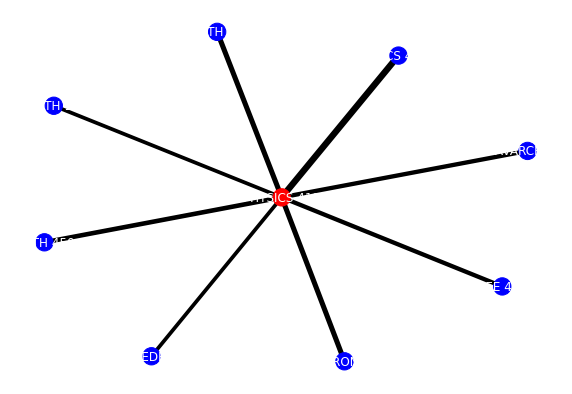

In [49]:
viz_similar_classes('PHYSICS 411', 8)

# Subject level investigation

### Subject level
- Concatinate all the descriptions for each subject
- Get a feel for the language used
- Consider seperating subjects by 100&200s / 300&400s

### Course level level
- Make a map of intro courses in LSA and ENG

In [50]:
concatenated_descriptions = combined_df.groupby('department')['description_x'].apply(' '.join).reset_index()

In [52]:
concatenated_descriptions['cleaned_description'] = concatenated_descriptions['description_x'].apply(clean_description)
concatenated_descriptions['cleaned_description'] = concatenated_descriptions['cleaned_description'].str.lower()

In [89]:
#This gets the top n most common words in concatinated descriptions
all_words = ' '.join(concatenated_descriptions['cleaned_description']).split()
word_freq = Counter(all_words)
top_words = [word for word, freq in word_freq.most_common(500)]
# Generate words
concatenated_descriptions['vector'] = concatenated_descriptions['cleaned_description'].apply(vectorize_description)

In [85]:
#Generate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

def course_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Make similarity matrix
matrix = [vec for vec in concatenated_descriptions['vector']]
# Compute cosine similarities
similarity_matrix = cosine_similarity(matrix)
#Find similar courses
deps = concatenated_descriptions['department'].tolist()
# For the 0th course
similarities = similarity_matrix[0]
similarities = np.delete(similarities, 0)  # remove self-similarity
most_similar_dep_index = np.argmax(similarities)

print(f"The subject most similar to {deps[0]} is {deps[most_similar_dep_index+1]} with a similarity of {similarities[most_similar_dep_index]:.2f}")

The subject most similar to AAS is HISTORY with a similarity of 0.89


In [86]:
get_similarity('EECS', 'PHYSICS', 'department', concatenated_descriptions, similarity_matrix)

0.679783777013594

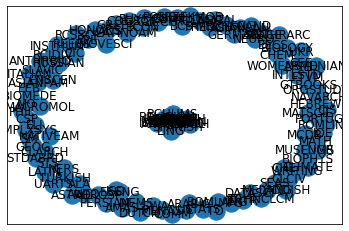

In [87]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = nx.Graph()

# Add nodes with the department names
for dept in deps:
    G.add_node(dept)


# Add weighted edges between nodes based on the similarity matrix
for i in range(len(deps)):
    for j in range(i+1, len(deps)):  # to ensure each pair is only considered once
        # In this example, we only add an edge if the similarity is above a certain threshold (e.g., 0.5)
        if similarity_matrix[i][j] > 0.8:
            G.add_edge(deps[i], deps[j], weight=similarity_matrix[i][j])

# Define the layout for our nodes 
pos = nx.spring_layout(G)

# Draw the nodes and edges
nx.draw_networkx_nodes(G, pos)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=weights)

# Draw the labels
nx.draw_networkx_labels(G, pos)
plt.show()

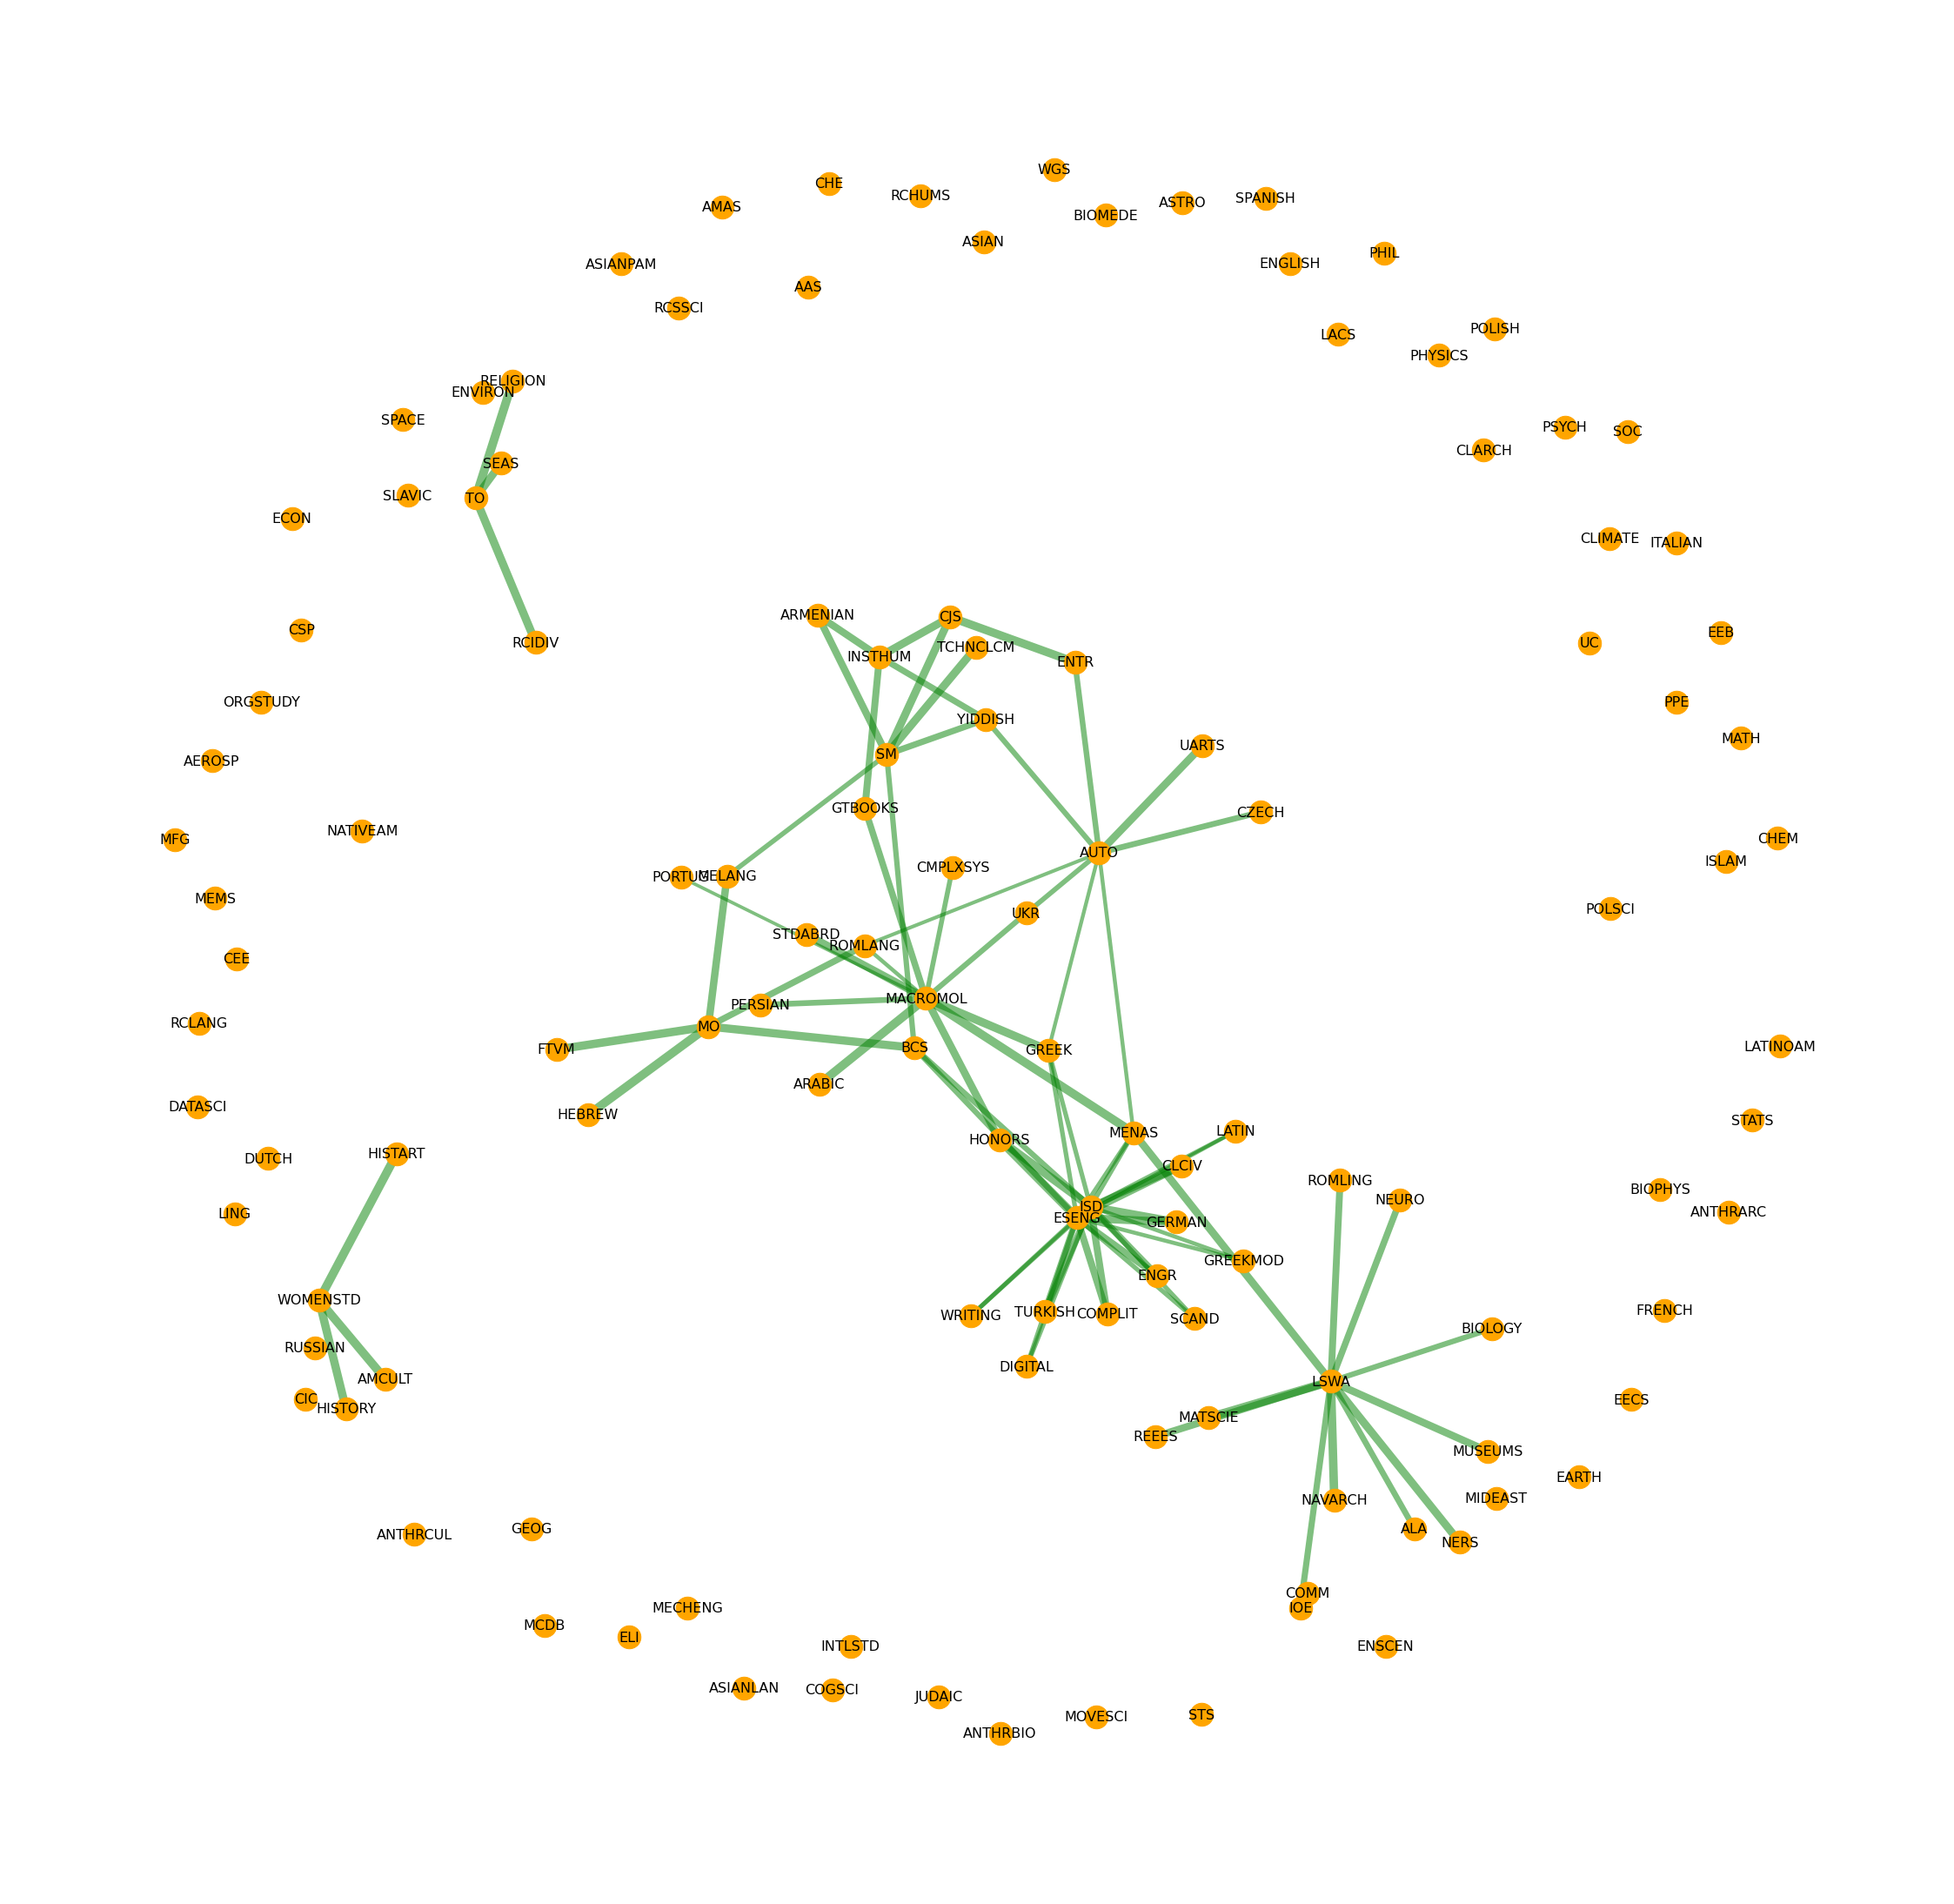

In [88]:
filtered_G = nx.Graph()

# Add only nodes with at least one edge and their corresponding edges weight is above a certain threshold
for i in range(len(deps)):
    for j in range(i+1, len(deps)):
        if similarity_matrix[i][j] < 0.05:
            filtered_G.add_node(deps[i])
            filtered_G.add_node(deps[j])
            filtered_G.add_edge(deps[i], deps[j], weight=similarity_matrix[i][j])

filtered_pos = nx.spring_layout(filtered_G)

edge_weights = np.array([filtered_G[u][v]['weight'] for u, v in filtered_G.edges()])
scaled_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min()) * 10  # Scale between 1 and 10 for visibility


plt.figure(figsize=(40, 40))
nx.draw_networkx_nodes(filtered_G, filtered_pos, node_size=700, node_color='orange')
nx.draw_networkx_edges(filtered_G, filtered_pos, width=scaled_weights, alpha=0.5, edge_color='g')
nx.draw_networkx_labels(filtered_G, filtered_pos, font_size=16, font_color='black')

plt.axis('off')
plt.show()

# Course Level (100 and 200s)

In [76]:
intro_df = combined_df[combined_df['level'] == 100]
all_words = ' '.join(intro_df['cleaned_description']).split()
word_freq = Counter(all_words)
top_words = [word for word, freq in word_freq.most_common(500)]

In [77]:
intro_df['vector'] = intro_df['cleaned_description'].apply(vectorize_description)

C:\Users\hvand\AppData\Local\Temp\ipykernel_17980\3742727875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intro_df['vector'] = intro_df['cleaned_description'].apply(vectorize_description)


In [78]:
def course_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Make similarity matrix
matrix = [vec for vec in combined_df['vector']]
# Compute cosine similarities
similarity_matrix = cosine_similarity(matrix)
#Find similar courses
course_names = combined_df['course'].tolist()

In [82]:
intro_G = nx.Graph()

# Add only nodes with at least one edge and their corresponding edges weight is above a certain threshold
for i in range(len(course_names)):
    for j in range(i+1, len(course_names)):
        if similarity_matrix[i][j] > 0.5:
            intro_G.add_node(course_names[i])
            intro_G.add_node(course_names[j])
            intro_G.add_edge(course_names[i], course_names[j], weight=similarity_matrix[i][j])

intro_pos = nx.spring_layout(intro_G)

edge_weights = np.array([intro_G[u][v]['weight'] for u, v in intro_G.edges()])
scaled_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min()) * 10  # Scale between 1 and 10 for visibility


plt.figure(figsize=(40, 40))
nx.draw_networkx_nodes(intro_G, intro_pos, node_size=700, node_color='orange')
nx.draw_networkx_edges(intro_G, intro_pos, width=scaled_weights, alpha=0.5, edge_color='g')
nx.draw_networkx_labels(intro_G, intro_pos, font_size=16, font_color='black')

plt.axis('off')
plt.show()

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

In [79]:
intro_df.shape

(357, 14)

In [71]:
top_words

['course',
 'students',
 'social',
 'history',
 'topics',
 'also',
 'political',
 'language',
 'research',
 'cultural',
 'analysis',
 'world',
 'study',
 'culture',
 'work',
 'include',
 'class',
 'including',
 'introduction',
 'issues',
 'american',
 'well',
 'gender',
 'historical',
 'studies',
 'literature',
 'development',
 'systems',
 'one',
 'writing',
 'century',
 'design',
 'modern',
 'new',
 'understanding',
 'focus',
 'theory',
 'human',
 'explore',
 'contemporary',
 'methods',
 'use',
 'environmental',
 'examine',
 'reading',
 'skills',
 'texts',
 'society',
 'media',
 'different',
 'many',
 'politics',
 'time',
 'economic',
 'women',
 'art',
 'ways',
 'problems',
 'emphasis',
 'various',
 'two',
 'major',
 'life',
 'learn',
 'science',
 'film',
 'literary',
 'explores',
 'student',
 'race',
 'field',
 'basic',
 'change',
 'questions',
 'people',
 'readings',
 'examines',
 'used',
 'experience',
 'range',
 'processes',
 'particular',
 'faculty',
 'honors',
 'period',
 'state

# 300s and 400s

In [69]:
upper_df = combined_df[combined_df['level'] > 200]
all_words = ' '.join(upper_df['cleaned_description']).split()
word_freq = Counter(all_words)
top_words = [word for word, freq in word_freq.most_common(500)]

In [70]:
top_words

['course',
 'students',
 'social',
 'history',
 'topics',
 'also',
 'political',
 'language',
 'research',
 'cultural',
 'analysis',
 'world',
 'study',
 'culture',
 'work',
 'include',
 'class',
 'including',
 'introduction',
 'issues',
 'american',
 'well',
 'gender',
 'historical',
 'studies',
 'literature',
 'development',
 'systems',
 'one',
 'writing',
 'century',
 'design',
 'modern',
 'new',
 'understanding',
 'focus',
 'theory',
 'human',
 'explore',
 'contemporary',
 'methods',
 'use',
 'environmental',
 'examine',
 'reading',
 'skills',
 'texts',
 'society',
 'media',
 'different',
 'many',
 'politics',
 'time',
 'economic',
 'women',
 'art',
 'ways',
 'problems',
 'emphasis',
 'various',
 'two',
 'major',
 'life',
 'learn',
 'science',
 'film',
 'literary',
 'explores',
 'student',
 'race',
 'field',
 'basic',
 'change',
 'questions',
 'people',
 'readings',
 'examines',
 'used',
 'experience',
 'range',
 'processes',
 'particular',
 'faculty',
 'honors',
 'period',
 'state

In [ ]:
concatenated_descriptions['vector'] = concatenated_descriptions['cleaned_description'].apply(vectorize_description)